<a href="https://colab.research.google.com/github/Chuck2Win/Variational_Auto_Encoder/blob/master/variational_auto_encoder(vanilla).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy
from matplotlib import pyplot as plt

In [2]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

In [3]:
# Data 읽어오기
mnist_train_data=torchvision.datasets.MNIST('./',train=True, transform=torchvision.transforms.ToTensor(),download=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [25]:
config=Config({'batch_size':512,'hidden_dim':256,'latent_dim':20,'input_size':28*28})

In [26]:
# data loader
train_data_loader=torch.utils.data.DataLoader(mnist_train_data,batch_size=config.batch_size,shuffle=True,drop_last=True)

In [6]:
class encoder(nn.Module):
    def __init__(self,config):
        super(encoder,self).__init__()
        self.config=config
        self.fc=nn.Sequential(nn.Linear(self.config.input_size,self.config.hidden_dim),nn.ReLU())
        self.mu=nn.Linear(self.config.hidden_dim,self.config.latent_dim)
        self.log_var=nn.Linear(self.config.hidden_dim,self.config.latent_dim)
        
    def forward(self,input):
        'input shape : batch_size, C, H, W -> batch_size, input_size + C=1,H,W=28 <- pre processed '
        x=self.fc(input)
        mu=self.mu(x)
        log_var=self.log_var(x)
        return mu,log_var
    
class decoder(nn.Module):
    def __init__(self,config):
        '''
        using sigmoid because of mnist data have 0~1 values <- normalized.
        '''
        super(decoder,self).__init__()
        self.config=config
        self.fc1=nn.Sequential(nn.Linear(self.config.latent_dim,self.config.hidden_dim),nn.ReLU())
        self.fc2=nn.Sequential(nn.Linear(self.config.hidden_dim,self.config.input_size),nn.Sigmoid()) 

    def forward(self,z):
        x=self.fc1(z)
        output=self.fc2(x)
        return output

In [7]:
class variational_auto_encoder(nn.Module):
    def __init__(self,config):
        super(variational_auto_encoder,self).__init__()
        self.config=config
        self.encoder=encoder(config)
        self.decoder=decoder(config)
        
    def reparametrization(self,mu,log_var):
        '''
        mu, log_var shape : batch_size,latent_dim.
        e ~ N_k(0,I_k) shape : batch_size,latent_dim
        in paper  
        cost(x_i) = -Eq(z|x_i)[log(p(x_i|z))]+KLD(q(z|x_i)|p(z))
        Eq(z|x_i)[log(p(x_i|z))]=1/L(sigma(log(p(x_i|z_i,l)))) l = 1~L "Monte Carlo Expectation estimate
        z_i,l = mu + e_i,l * sigma 
        '''
        sigma=torch.exp(0.5*log_var)
        e=torch.randn_like(sigma,device=sigma.device) # strictly speaking, e shape : batch size, L, latent dim
        z=mu+sigma*e
        return z
        
    def forward(self,input):
        mu,log_var=self.encoder(input)
        self.z=self.reparametrization(mu,log_var)
        output=self.decoder(self.z)
        return output,mu,log_var


In [8]:
def total_loss(decoder_output,input,mu,log_var):
    batch_size=mu.size(0)
    BCE=F.binary_cross_entropy(decoder_output,input,reduction='sum')
    KL=-0.5*(log_var.sum()+1.*batch_size-log_var.exp().sum()-mu.pow(2).sum())
    return (BCE+KL)/batch_size,BCE/batch_size,KL/batch_size

torch.Size([64, 20])

In [28]:
a=torch.zeros((512,20))
KL=-0.5*(a.sum()+1.*64-a.exp().sum()-a.pow(2).sum())/512
print(KL)

tensor(9.9375)


In [24]:
KL=-0.5*(log_var.sum()+1.*64-log_var.exp().sum()-mu.pow(2).sum())/512
print(KL)

tensor(34.7858, device='cuda:0', grad_fn=<DivBackward0>)


In [29]:
import time
from tqdm import tqdm
device='cuda'
epochs=100
Total_loss=[]
Ce_loss=[]
Kl_loss=[]
model=variational_auto_encoder(config).to(device)
optimizer=torch.optim.Adam(model.parameters())
cost=[]
for epoch in tqdm(range(epochs),desc='epoch',mininterval=60):
    total_loss=0
    ce_loss=0
    kl_loss=0
    for x,_ in train_data_loader:
        optimizer.zero_grad()
        x=x.reshape(-1,config.input_size).to(device)
        output,mu,log_var=model(x)
        batch_size=mu.size(0)
        BCE=F.binary_cross_entropy(output,x,reduction='sum')/batch_size
        KL=(-(0.5*(log_var.sum()+1.*batch_size-log_var.exp().sum()-mu.pow(2).sum())))/batch_size
        loss=(BCE+KL)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        ce_loss+=BCE.item()
        kl_loss+=KL.item()
    Total_loss.append(total_loss/len(train_data_loader))
    Ce_loss.append(ce_loss/len(train_data_loader))
    Kl_loss.append(kl_loss/len(train_data_loader))

    if epoch%10==0:
        print('epoch', epoch)
        print('total loss : %.2f'%(total_loss/len(train_data_loader)))
        print('cross entropy : %.2f'%(ce_loss/len(train_data_loader)))
        print('kl divergence : %.2f'%(kl_loss/len(train_data_loader)))   
    



epoch:   0%|          | 0/100 [00:00<?, ?it/s]

epoch 0
total loss : 245.81
cross entropy : 224.65
kl divergence : 21.15
epoch 10
total loss : 123.45
cross entropy : 89.63
kl divergence : 33.82




epoch:  13%|█▎        | 13/100 [01:00<06:44,  4.65s/it]

epoch:  13%|█▎        | 13/100 [01:19<06:44,  4.65s/it]

epoch 20
total loss : 118.49
cross entropy : 83.82
kl divergence : 34.67




epoch:  26%|██▌       | 26/100 [02:00<05:43,  4.64s/it]

epoch:  26%|██▌       | 26/100 [02:19<05:43,  4.64s/it]

epoch 30
total loss : 116.48
cross entropy : 81.59
kl divergence : 34.89




epoch:  40%|████      | 40/100 [03:04<04:37,  4.63s/it]

epoch 40
total loss : 115.30
cross entropy : 80.35
kl divergence : 34.95




epoch:  40%|████      | 40/100 [03:19<04:37,  4.63s/it]

epoch 50
total loss : 114.53
cross entropy : 79.57
kl divergence : 34.96




epoch:  54%|█████▍    | 54/100 [04:09<03:32,  4.62s/it]

epoch:  54%|█████▍    | 54/100 [04:19<03:32,  4.62s/it]

epoch 60
total loss : 113.96
cross entropy : 78.96
kl divergence : 35.00




epoch:  68%|██████▊   | 68/100 [05:13<02:27,  4.61s/it]

epoch 70
total loss : 113.49
cross entropy : 78.48
kl divergence : 35.01




epoch:  68%|██████▊   | 68/100 [05:29<02:27,  4.61s/it]

epoch 80
total loss : 113.16
cross entropy : 78.14
kl divergence : 35.01




epoch:  82%|████████▏ | 82/100 [06:18<01:23,  4.61s/it]

epoch:  82%|████████▏ | 82/100 [06:29<01:23,  4.61s/it]

epoch 90
total loss : 112.82
cross entropy : 77.86
kl divergence : 34.97




epoch:  96%|█████████▌| 96/100 [07:22<00:18,  4.60s/it]

epoch: 100%|██████████| 100/100 [07:40<00:00,  4.61s/it]


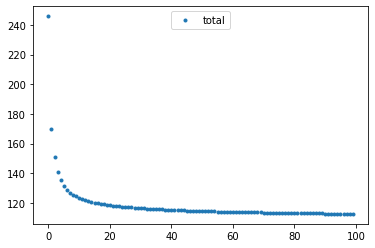

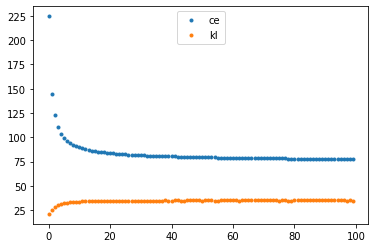

In [32]:
plt.plot(Total_loss,'.',label='total')
plt.legend(loc=9)
plt.show()
plt.plot(Ce_loss,'.',label='ce')
plt.plot(Kl_loss,'.',label='kl')
plt.legend(loc=9)
plt.show()

In [35]:
def generator(mu,log_var,n):
    model.eval()
    e=torch.randn_like(log_var,device=log_var.device)
    z=mu+torch.exp(0.5*log_var)*e
    with torch.no_grad():
        output=model.decoder(z)
    image=output.cpu().reshape(-1,28,28)
    for i in range(n):
        plt.imshow(image[i,:,:])
        plt.show()

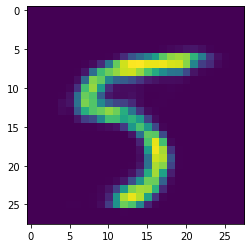

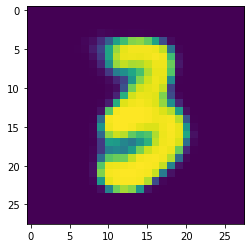

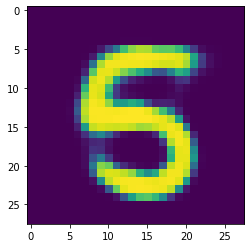

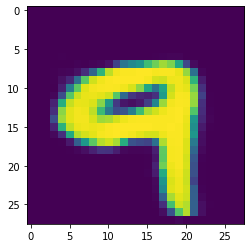

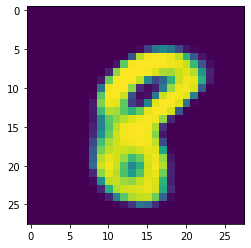

In [36]:
generator(mu,log_var,5)